<h4 style="color:red"> 
The first part of this notebook is just code and trial-runs of the code. 
    The assignment solutions are further below
    </h4> 

# Problem Description
<details>
    
The Poisson Equation is given as 
$$ -\frac{\partial^2 u(x,y)}{\partial x^2} -\frac{\partial^2 u(x,y)}{\partial y^2}  = f(x,y)$$
$$f(x,y) = - [(6x-4)y(y-1) + 2x(x-1)^2] $$
having exact solution $u(x,y)$ given by 
$$u(x, y) = x(x − 1)^2y(y − 1)$$
where $(x,y)$ is defined in the region $\Omega = (0,1) \times (0,1) $ with the boundary condition $ u(x,y)\vert_{\partial \Omega} = 0 $

Upon discretizing it, we get the following finite-difference approximation

$$ - \left[ \frac{U_{i+1,j} - 2 U_{i,j} + U_{i-1,j} }{h^2} \right] - \left[ \frac{U_{i,j+1} - 2 U_{i,j} + U_{i,j-1} }{h^2} \right] = f_{i,j}$$

<!-- $$ U_{i,j} = x_i(x_i-1)^2y_j(y_j - 1)$$ -->

$$ f_{i,j} = -[(6x_i - 4)y_j(y_j-1) + 2x_i(x_i-1)^2]$$

$$ U_{0,j} = U_{N,j} = U_{i,0} = U_{i,N} = 0 \text{ for }  i,j \in 0,1,2...N$$ 
where $U_{i,j} = u(x_i,y_j)$, $f_{i,j} = f(x_i,y_j)$, $x_i = ih$, $y_j = jh$, and $h = 1/N$ is the grid-resolution 


## Metrics for error and convergence
The $\textbf{Residual}$ is defined as 

$$r_{i,j} = f_{i,j} - f^{(k)}_{i,j}$$

where $f^{(k)}_{i,j} = -\frac{1}{h^2}\left[ U_{i+1,j}^{(k)} + U_{i-1,j}^{(k)} + U_{i,j+1}^{(k)} + U_{i,j-1}^{(k)} - 4U_{i,j}^{(k)} \right]$ and $f_{ij}$ is the exact solution to $f(x_i,y_j)$ 

The $\textbf{Error Norm}$ is defined as 
$$ 
E^{(k)} = \Vert U_{i,j} - U_{i,j}^{(k)} \Vert_{2} = \sqrt{\Sigma_{i = 1}^{N-1} \Sigma_{j=1}^{N-1} \left[ U_{i,j} - U_{i,j}^{(k)} \right]^2 h^2}
$$ 
where $U_{i,j}$ is the exact solution to $U(x_i,y_j)$

The $\textbf{Average Rate of Convergence}$ is defined as 
$$ 
\mathcal{R}^{(k)} = -\frac{1}{k} \ln \left( \frac{E^{(k)}}{E^{(0)}} \right) 
$$ 

<\details>

In [51]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#### Define helper functions to compute $f(x_i,y_j)$ and $u(x_i,y_j)$ analytically
<details>
    
- Define helper functions $\texttt{AnalyticalLaplacian(N)}$ to compute the matrix $\texttt{f}$ where $\texttt{f[i,j]} = f(x_i,y_j)= -[(6x_i - 4)y_j(y_j-1) + 2x_i(x_i-1)^2]$.
- $\texttt{AnalyticalLaplacian(N)}$  will be useful for evaluating $U_{i,j}^{(k)}$ and the $\textbf{residual}$
- Define helper function $\texttt{AnalyticalSolution(N)}$ to compute the the matrix $\texttt{U}$ where $\texttt{U[i,j]} = u(x_i,y_j) = (x_i)(x_i-1)^2(y_j)(y_j-1)$.
- $\texttt{AnalyticalSolution(N)}$ will be useful for evaluating the $\textbf{norm of the error}$ and the $\textbf{average rate of convergence}$
</details>

In [2]:
# Helper functions for analytical values and initial conditions 
# The analytical-solution for the Laplacian, solved for an NxN grid
def AnalyticalLaplacian(N):
    LAP = np.full((N,N), 0.0)
    h = 1.0/(N-1)
    for i in range(0,N):
        for j in range(0,N):
            xi,yj = i*h, j*h
            LAP[i][j] = -((6*xi-4)*yj*(yj-1) + 2*xi*(xi-1)*(xi-1))
    return LAP        

# Solves the analytical-solution for an NxN grid with Dirichlet Boundary Conditions by default
def AnalyticalSolution(N,dirichlet_bc=True):
    U = np.full((N,N), 0.0)
    h = 1.0/(N-1)
    for i in range(0,N):
        for j in range(0,N):
            xi,yj = i*h, j*h
            U[i][j] = xi*(xi-1)*(xi-1)*yj*(yj-1)

    # Boolean for applying Dirichlet Boundary Conditions
    if dirichlet_bc:
        U[[0, -1], :] = U[:, [0, -1]] = 0 # apply Dirichlet boundary 
        
    return U

# returns an NxN matrix of zeros
def DefaultInitialGuess(N):
    return np.zeros((N,N))

#### Define helper functions to compute Residual-Norm, Error-Norm, and Average rate of convergence

In [3]:
# Helper functions for computing Residual-Norm, Error-Norm, Average-Rate-Of-Convergence
# dont include U[0][j], U[-1][j], U[i][0], U[i][-1] in the evaluation 
# of residuals and error-norm because those are boundary values

# Uk - kth iteration of U
# LAP - analytical solution to laplacian
def ResidualNorm(Uk, LAP):
    N = Uk.shape[0]
    h = 1.0/(N-1)
    h2 = h**2
    r = np.full((N,N), 0.0) # Residue Matrix
    for i in range(1,N-1):
        for j in range(1,N-1):
            left = Uk[i-1,j]
            right = Uk[i+1,j]
            up = Uk[i,j-1]
            down = Uk[i,j+1]
            curr = Uk[i,j]
            LAP_k = -(left + right + up + down - 4*curr)/h2
            r[i,j] = LAP[i,j] - LAP_k

    res_norm = np.sqrt(np.sum(r[1:N, 1:N]**2))
    return res_norm

# Uk - kth iteration of U
# U - analytical solution to U(x,y)
def ErrorNorm(Uk,U):
    N = Uk.shape[0]
    h = 1.0/(N-1)
    norm = 0.0
    for i in range(1,N-1):
        for j in range(1,N-1):
            err = (U[i,j] - Uk[i,j])
            norm+= (err*h)**2
    return np.sqrt(norm)

def AverageROC(Ek,E0,k):
    if Ek <= 0 or E0 <= 0 or k == 0: 
        return 0.0
    aroc = -np.log(Ek/E0)/k
    return aroc

#### Define helper function for computing various theoretical values

In [4]:
# Helper functions for computing various theoretical values 

# Theoretical Value of AROC for Jacobi
def JacobiTheoreticalAROC(N):
    h = 1/(N-1)
    pi2 = np.pi**2
    h2 = h**2
    return pi2*h2/2

# Theoretical Value of AROC for GS
def GaussSeidelTheoreticalAROC(N):
    return JacobiTheoreticalAROC(N)*2

# Theoretical Value of AROC for SOR
def SORTheoreticalAROC(N):
    h = 1/(N-1)
    return 2 * np.pi * h
    
# Theoretical Value of AROC for SSOR
def SSORTheoreticalAROC(N):
    return SORTheoreticalAROC(N)/2


# Theoretical Value of K for Jacobi
def JacobiTheoreticalK(N):
    h = 1/(N-1)
    lnh = np.log(h)
    return 2 * np.abs(lnh) / JacobiTheoreticalAROC(N)

# Theoretical Value of K for GS
def GaussSeidelTheoreticalK(N):
    return JacobiTheoreticalK(N)/2

# Theoretical Value of K for SOR
def SORTheoreticalK(N):
    h = 1/(N-1)
    lnh = np.log(h)
    return 2 * np.abs(lnh) / (np.pi * h)

# Theoretical Value of K for SSOR
def SSORTheoreticalK(N):
    return 2 * SORTheoreticalK(N)

# Theoretical Value of omega_opt for SOR
def OmegaOpt(N):
    h = 1/(N-1)
    pih = np.pi * h
    return 2/(1 + np.sin(pih))

# Theoretical Value of omega_good for SSOR
def OmegaGood(N):
    h = 1/(N-1)
    pih = np.pi * h
    return 2/(1 + np.sqrt(2*(1 - np.cos(pih))))


<html><br></html>

--------------------------------------------------------

--------------------------------------------------------

<html><br></html>

# Jacobi Solver code
$$ U_{i,j} ^{(k+1)} = \frac{1}{4} \left[ h^2 f_{i,j} + U_{i+1,j}^{(k)} + U_{i-1,j}^{(k)} + U_{i,j+1}^{(k)} + U_{i,j-1}^{(k)}  \right]$$ 

In [5]:
# Jacobi Solver
# U0 - initial guess
# LAP - analytical laplacian
# U - analytcical solution to U(x,y)
def JacobiSolver(U0, LAP, U, max_iter=200, tolerance = 1e-6):
# when iterating through row_i and col_j remember that U[0][:] = U[-1][:] = U[:][0] = U[:][-1] = 0 so dont update those
    U_prev = U0.copy()
    U_curr = U0.copy()
    res_norm = np.full(max_iter, 0.0)
    err_norm = np.full(max_iter, 0.0)
    aroc     = np.full(max_iter, 0.0)
    
    N = U0.shape[0] # number of grids 
    h = 1.0/(N-1) # grid-resolution
    h2 = h**2
    
    for k in range(max_iter):
        for i in range(1,N-1):
            for j in range(1,N-1):
                fterm  = h2*LAP[i][j]
                left   = U_prev[i-1 , j]
                right  = U_prev[i+1 , j]
                down   = U_prev[i , j+1]
                up     = U_prev[i , j-1]
                
                U_curr[i][j] = 0.25 * (fterm + left + right + up + down)
                
        res_norm[k] = ResidualNorm(U_curr,LAP)
        err_norm[k] = ErrorNorm(U_curr, U)
        aroc[k]     = AverageROC(err_norm[k], err_norm[0], k)
        
        U_prev = U_curr.copy() 
        # (U_prev,U_curr) = (U_curr,U_prev) # efficient swap

        # check for convergence
        # if res_norm[k] < tolerance:
            # print(f"Converged after {k} iterations, residual = {res_norm[k]:.2e}")
            # break
        
    return ({
        "Uk":U_curr,
        "res":res_norm,
        "err":err_norm,
        "aroc":aroc
    })

### Trial run of Jacobi Solver

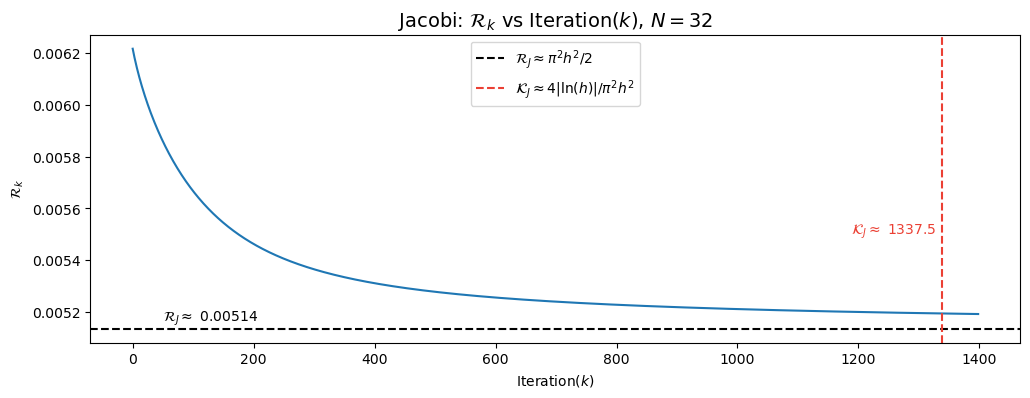

In [32]:
# Plot Jacobi's AROC vs Iteration, for N = 32
plt.figure(figsize=(12,4))
jacobi_32 = JacobiSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), max_iter = 1400)
plt.plot(jacobi_32["aroc"][1:])
plt.title("Jacobi: $\\mathcal{R}_{k}$ vs Iteration($k$), $N=32$",fontsize=14)
plt.xlabel("Iteration($k$)")
plt.ylabel("$\\mathcal{R}_{k}$")
aroc_jacobi32 = JacobiTheoreticalAROC(32) 
k_jacobi32 = JacobiTheoreticalK(32)
plt.axhline(y=aroc_jacobi32, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{J} \\approx \\pi^2h^2/2$')
plt.axvline(x=k_jacobi32, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{J} \\approx 4|\\ln(h)|/\\pi^2h^2$')
plt.text(50, aroc_jacobi32 + 0.00003, f"$\\mathcal{{R}}_{{J}} \\approx $ {aroc_jacobi32:.5f}", color='black')
plt.text(k_jacobi32 - 150, 0.0055, f"$\\mathcal{{K}}_{{J}} \\approx $ {k_jacobi32:.1f}", color='#eb4034')
plt.legend()
plt.show()


<html><br></html>

--------------------------------------------------------

--------------------------------------------------------

<html><br></html>

# Gauss-Seidel Solver code
$$ U_{i,j} ^{(k+1)} = \frac{1}{4} \left[ h^2 f_{i,j} + U_{i+1,j}^{(k)} + U_{i-1,j}^{(k+1)} + U_{i,j+1}^{(k)} + U_{i,j-1}^{(k+1)}  \right]$$ 


In [7]:
# Gauss-Seidel Solver
def GaussSeidelSolver(U0, LAP, U, max_iter=200, tolerance = 1e-6):
    Uk = U0.copy()
    res_norm = np.full(max_iter, 0.0)
    err_norm = np.full(max_iter, 0.0)
    aroc  = np.full(max_iter, 0.0)

    N = U0.shape[0]
    h = 1.0/(N-1)
    h2 = h**2
    for k in range(max_iter):
        for i in range(1,N-1):
            for j in range(1,N-1):
                fterm  = h2*LAP[i,j]
                left   = Uk[i-1 , j]
                right  = Uk[i+1 , j]
                down   = Uk[i , j+1]
                up     = Uk[i , j-1]
                Uk[i][j] = 0.25 * (fterm + left + right + up + down)

        res_norm[k] = ResidualNorm(Uk,LAP)
        err_norm[k] = ErrorNorm(Uk, U)
        aroc[k] = AverageROC(err_norm[k], err_norm[0], k)

        # if res_norm[k] < tolerance:
            # print(f"Converged after {k} iterations, residual = {res_norm[k]:.2e}")
            # break
    return ({
        "Uk":Uk,
        "res":res_norm,
        "err":err_norm,
        "aroc":aroc
    })

### Trial run of Gauss-Seidel Solver

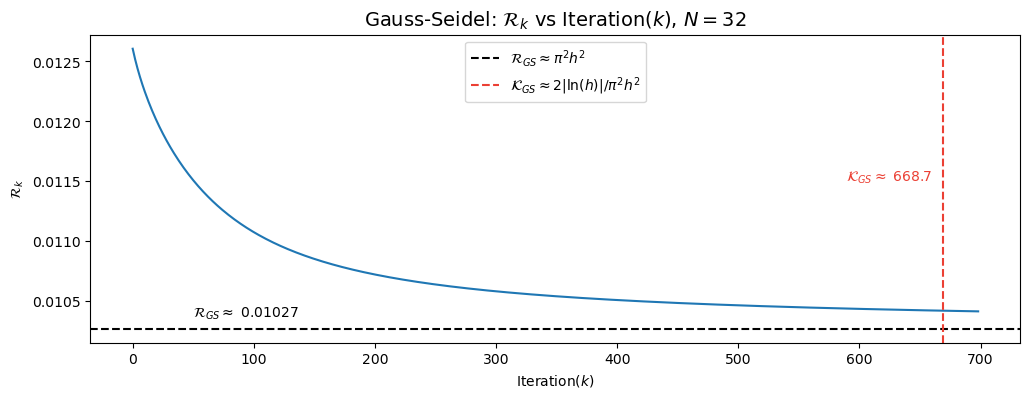

In [33]:
# Plot Gauss-Seidel's AROC vs Iteration, for N = 32
plt.figure(figsize=(12,4))
gs_32 = GaussSeidelSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), max_iter = 700)
plt.plot(gs_32["aroc"][1:])
plt.title("Gauss-Seidel: $\\mathcal{R}_{k}$ vs Iteration($k$), $N=32$",fontsize=14)
plt.xlabel("Iteration($k$)")
plt.ylabel("$\\mathcal{R}_{k}$")
aroc_gs32 = GaussSeidelTheoreticalAROC(32)
k_gs32 = GaussSeidelTheoreticalK(32)
plt.axhline(y=aroc_gs32, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{GS} \\approx \\pi^2h^2$')
plt.axvline(x=k_gs32, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{GS} \\approx 2|\\ln(h)|/\\pi^2h^2$')
plt.text(50, aroc_gs32 + 0.0001, f"$\\mathcal{{R}}_{{GS}} \\approx $ {aroc_gs32:.5f}", color='black')
plt.text(k_gs32 - 80, 0.0115, f"$\\mathcal{{K}}_{{GS}} \\approx $ {k_gs32:.1f}", color='#eb4034')
plt.legend()
plt.show()

<html><br></html>

--------------------------------------------------------

--------------------------------------------------------

<html><br></html>

# SOR Solver code
$$ U_{i,j}^{(k+1)} = \omega G_{i,j}^{(k+1)} + (1-\omega) U_{i,j}^{(k)} $$ 
where $G_{ij}^{(k)}$ is the ${k^{th}}$ iteration of the Gauss-Seidel

In [9]:
def SORSolver(U0, LAP, U, omega, max_iter=200, tolerance = 1e-6):
    Uk = U0.copy()
    res_norm = np.full(max_iter, 0.0)
    err_norm = np.full(max_iter, 0.0)
    aroc  = np.full(max_iter, 0.0)

    N = U0.shape[0]
    h = 1.0/(N-1) # this seems to matter for convergence of AROC. choosing 1/N changes the AROC asymptote
    h2 = h**2
    
    for k in range(max_iter):
        for i in range(1,N-1):
            for j in range(1,N-1):
                fterm   = h2*LAP[i,j]
                left    = Uk[i-1 , j]
                right   = Uk[i+1 , j]
                down    = Uk[i , j+1]
                up      = Uk[i , j-1]
                gij     = 0.25 * (fterm + left + right + down + up) # gauss-seidel
                Uk[i,j] = omega * gij + (1-omega) * Uk[i,j]
    
    
        res_norm[k] = ResidualNorm(Uk,LAP)
        err_norm[k] = ErrorNorm(Uk, U)
        aroc[k]  = AverageROC(err_norm[k], err_norm[0], k)

        # if res_norm[k] < tolerance:
            # print(f"Converged after {k} iterations, residual = {res_norm[k]:.2e}")
            # break
        
    return ({
        "Uk":Uk, 
        "res":res_norm, 
        "err":err_norm, 
        "aroc":aroc
    }) 

### Trial run of SOR Solver

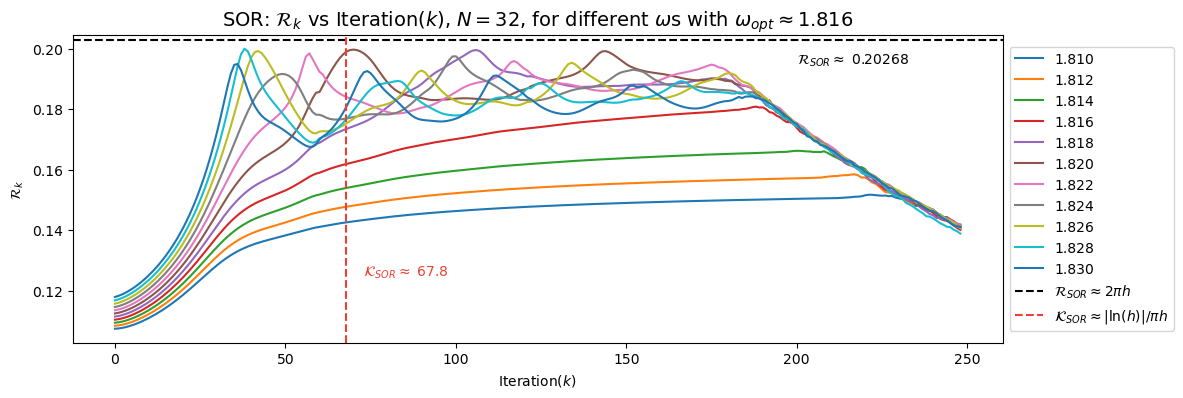

In [29]:
# look at aroc vs omega relation for a range of omegas for SOR for N = 32
plt.figure(figsize=(12,4))
for o in np.linspace(1.81,1.83,11):
    sor_omega = SORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = o, max_iter = 250)
    plt.plot(sor_omega["aroc"][1:], label = f"{o:.3f}")
plt.title("SOR: $\\mathcal{R}_{k}$ vs Iteration($k$), $N=32$, for different $\\omega$s with $\\omega_{opt} \\approx 1.816$",fontsize=14)
plt.xlabel("Iteration($k$)")
plt.ylabel("$\\mathcal{R}_{k}$")
aroc_sor32 = SORTheoreticalAROC(32)
k_sor32 = SORTheoreticalK(32)
plt.axhline(y=aroc_sor32, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{SOR} \\approx 2\\pi h$')
plt.axvline(x=k_sor32, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{SOR} \\approx |\\ln(h)|/\\pi h$')
plt.text(200, 0.195, f"$\\mathcal{{R}}_{{SOR}} \\approx $ {aroc_sor32:.5f}", color='black')
plt.text(k_sor32 + 5, 0.125, f"$\\mathcal{{K}}_{{SOR}} \\approx $ {k_sor32:.1f}", color='#eb4034')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



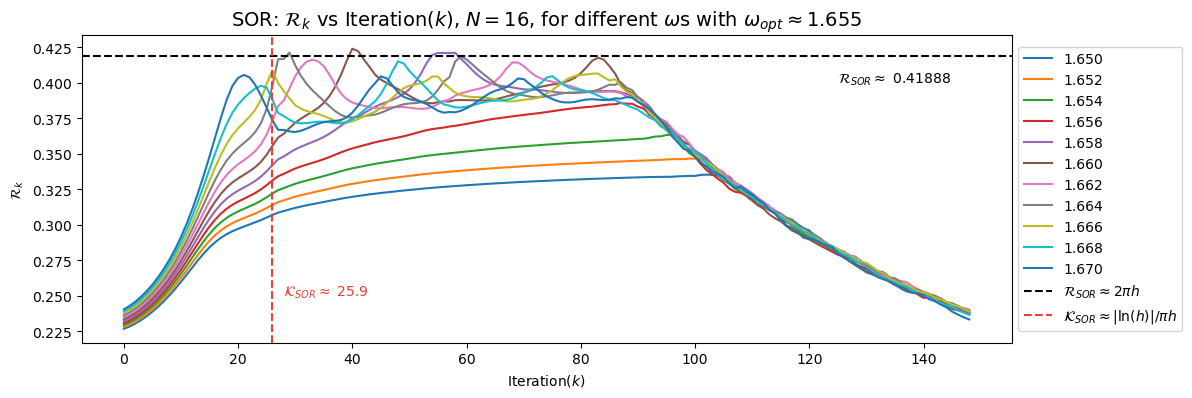

In [30]:
# look at aroc vs omega relation for a range of omegas for SOR for N = 16
plt.figure(figsize=(12,4))
for o in np.linspace(1.65,1.67,11):
    sor_omega = SORSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), omega = o, max_iter = 150)
    plt.plot(sor_omega["aroc"][1:], label = f"{o:.3f}")
plt.title("SOR: $\\mathcal{R}_{k}$ vs Iteration($k$), $N=16$, for different $\\omega$s with $\\omega_{opt} \\approx 1.655$",fontsize=14)
plt.xlabel("Iteration($k$)")
plt.ylabel("$\\mathcal{R}_{k}$")
aroc_sor16 = SORTheoreticalAROC(16)
k_sor16 = SORTheoreticalK(16)
plt.axhline(y=aroc_sor16, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{SOR} \\approx 2\\pi h$')
plt.axvline(x=k_sor16, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{SOR} \\approx |\\ln(h)|/\\pi h$')
plt.text(125, 0.4, f"$\\mathcal{{R}}_{{SOR}} \\approx $ {aroc_sor16:.5f}", color='black')
plt.text(k_sor16 + 2, 0.25, f"$\\mathcal{{K}}_{{SOR}} \\approx $ {k_sor16:.1f}", color='#eb4034')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



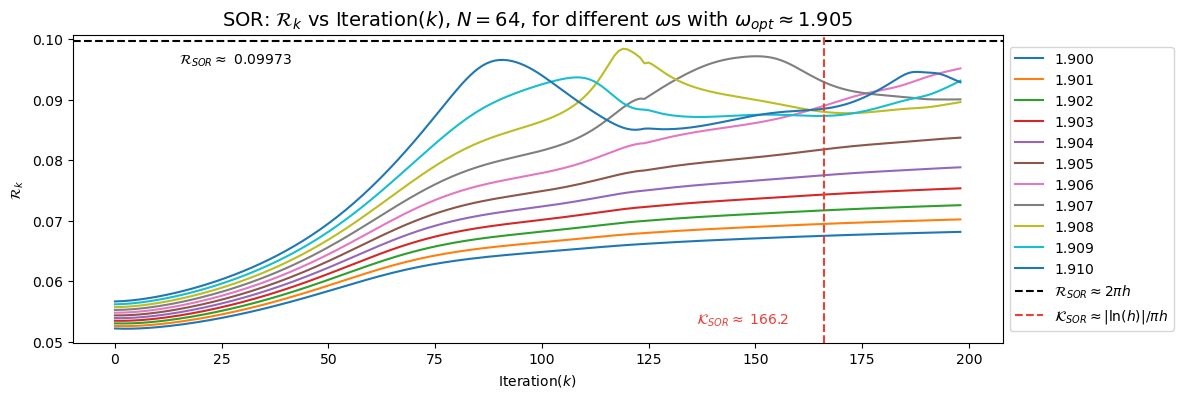

In [50]:
# look at aroc vs omega relation for a range of omegas for SOR for N = 64
plt.figure(figsize=(12,4))
for o in np.linspace(1.9,1.91,11):
    sor_omega = SORSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), omega = o, max_iter = 200)
    plt.plot(sor_omega["aroc"][1:], label = f"{o:.3f}")
plt.title("SOR: $\\mathcal{R}_{k}$ vs Iteration($k$), $N=64$, for different $\\omega$s with $\\omega_{opt} \\approx 1.905$",fontsize=14)
plt.xlabel("Iteration($k$)")
plt.ylabel("$\\mathcal{R}_{k}$")
aroc_sor64 = SORTheoreticalAROC(64)
k_sor64 = SORTheoreticalK(64)
plt.axhline(y=aroc_sor64, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{SOR} \\approx 2\\pi h$')
plt.axvline(x=k_sor64, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{SOR} \\approx |\\ln(h)|/\\pi h$')
plt.text(15, 0.096, f"$\\mathcal{{R}}_{{SOR}} \\approx $ {aroc_sor64:.5f}", color='black')
plt.text(k_sor64-30, 0.053, f"$\\mathcal{{K}}_{{SOR}} \\approx $ {k_sor64:.1f}", color='#eb4034')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



<html><br></html>

--------------------------------------------------------

--------------------------------------------------------

<html><br></html>

# SSOR Solver code
$$ U_{i,j}^{(k+1/2)} = (1-\omega)U_{i,j}^{(k)}  + \frac{\omega}{4} \left[ h^2 f_{i,j} + U_{i+1,j}^{(k)} + U_{i,j+1}^{(k)} + U_{i-1,j}^{(k+1/2)} + U_{i,j-1}^{k+1/2}\right] \quad \quad \texttt{Forward Pass}$$

$$ U_{i,j}^{(k+1)} = (1-\omega)U_{i,j}^{(k+1/2)}  + \frac{\omega}{4} \left[ h^2 f_{i,j} + U_{i+1,j}^{(k+1/2)} + U_{i,j+1}^{(k+1/2)} + U_{i-1,j}^{(k+1)} + U_{i,j-1}^{k+1}\right] \quad \texttt{Backward Pass} $$

In [12]:
def SSORSolver(U0, LAP, U, omega, max_iter=200, tolerance=1e-6):
    N = U0.shape[0]
    h = 1.0 / (N - 1)
    h2 = h**2

    Uk = U0.copy()
    res_norm = np.full(max_iter,0.0)
    err_norm = np.full(max_iter,0.0)
    aroc = np.full(max_iter,0.0)

    for k in range(max_iter):
        
        # Forward sweep 1 --> N
        U_old = Uk.copy()
        for i in range(1, N-1):
            for j in range(1, N-1):
                f_term = h2 * LAP[i][j]
                left  = Uk[i-1][j]
                right = U_old[i+1][j]
                up    = Uk[i][j-1]
                down = U_old[i][j+1]
                gij = 0.25 * (f_term + left + right + up + down)
                Uk[i][j] = (1 - omega) * Uk[i][j] + omega * gij

        # Reverse sweep N --> 1
        U_old = Uk.copy()
        for i in range(N-2, 0, -1):
            for j in range(N-2, 0, -1):
                f_term = h2 * LAP[i][j]
                right = Uk[i+1][j]
                down  = Uk[i][j+1]
                left  = U_old[i-1][j]
                up    = U_old[i][j-1]
                gij = 0.25 * (f_term + left + right + up + down)
                Uk[i][j] = (1 - omega) * Uk[i][j] + omega * gij

        res_norm[k] = ResidualNorm(Uk, LAP)
        err_norm[k] = ErrorNorm(Uk, U)
        aroc[k]  = AverageROC(err_norm[k], err_norm[0], k)

        # if res_norm[k] < tolerance:
            # print(f"Converged after {k} iterations, residual = {res_norm[k]:.3e}")
            # break

    return ({
        "Uk":Uk, 
        "res":res_norm, 
        "err":err_norm, 
        "aroc":aroc
    }) 

### Trial Run of SSOR Solver

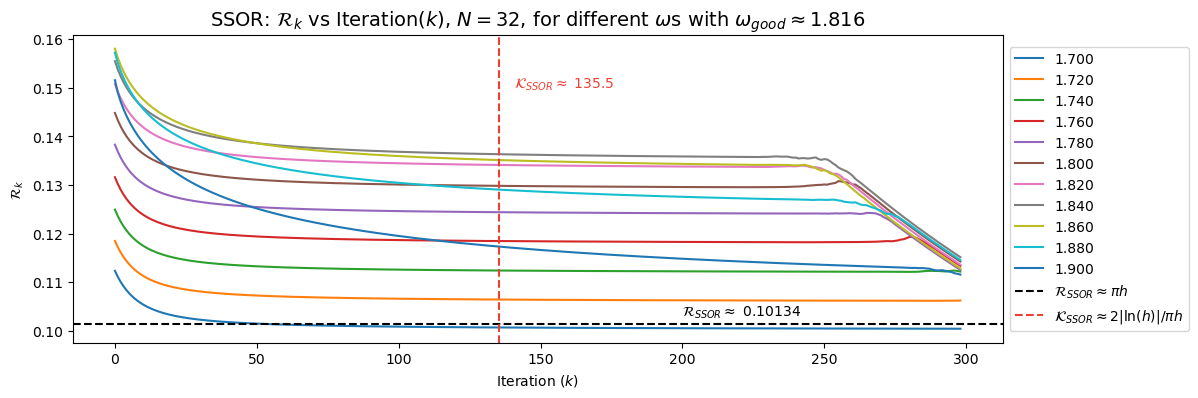

In [27]:
# plot SSOR's AROC vs iteration, for a range of omegas, at N = 32
plt.figure(figsize=(12,4))
for o in np.linspace(1.70,1.9,11):
    ssor_omega = SSORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = o, max_iter = 300)
    plt.plot(ssor_omega["aroc"][1:], label = f"{o:.3f}")
plt.title("SSOR: $\\mathcal{R}_{k}$ vs Iteration($k$), $N=32$, for different $\\omega$s with $\\omega_{good} \\approx 1.816$",fontsize=14)
plt.xlabel("Iteration ($k$)")
plt.ylabel("$\\mathcal{R}_{k}$")
aroc_ssor32 = SSORTheoreticalAROC(32)
k_ssor32 = SSORTheoreticalK(32)
plt.axhline(y=aroc_ssor32, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{SSOR} \\approx \\pi h$')
plt.axvline(x=k_ssor32, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{SSOR} \\approx 2|\\ln(h)|/\\pi h$')
plt.text(200, 0.103, f"$\\mathcal{{R}}_{{SSOR}} \\approx $ {aroc_ssor32:.5f}", color='black')
plt.text(k_ssor32 + 5, 0.15, f"$\\mathcal{{K}}_{{SSOR}} \\approx $ {k_ssor32:.1f}", color='#eb4034')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


<html><br></html>

--------------------------------------------------------

--------------------------------------------------------

<html><br></html>

<h3 style = "color:red"> !! Solutions to the assignment below !! </h3>

<h2 style = "color:red"> Homework 1.7  </h2>

Show that that the solution to the above poisson equation is given by $ u(x, y) = x(x − 1)^2y(y − 1)$
## Answer 1.7
<!-- <details> -->
    
This can be shown by simply differentiating $u(x,y)$ twice. 
    \begin{equation}
    \begin{split}
    \frac{\partial u}{\partial x} &= (x-1)^2 y (y-1) + 2x(x-1)y(y-1) \\ 
    \frac{\partial^2 u}{\partial x^2} &= 2(x-1) y (y-1) + 2(x-1)y(y-1) + 2xy(y-1) = (6x-4)y(y-1)\\ 
    \frac{\partial u}{\partial y} &= x(x-1)^2(y-1) + x(x-1)^2 y \\ 
    \frac{\partial^2 u}{\partial y^2} &= x(x-1)^2 + x(x-1)^2 = 2x(x-1)^2
    \end{split}
    \end{equation}

Adding the terms for $\partial^2 u / \partial x^2$ and $\partial^2 u/\partial y^2$ we get 
$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = (6x-4)y(y-1) + 2x(x-1)^2 = -f(x,y)$$
$$ \therefore -\Delta u(x,y) = f(x,y)$$ 
<!-- </details> -->

<html><br></html>

--------------------------------------------------------

--------------------------------------------------------

<html><br></html>

<h2 style = "color:red"  > Homework 1.8 </h2>
Show that $u(x,y) = x(x-1)^2y(y-1)$ and $f(x,y) = -[(6x-4)y(y-1) + 2x(x-1)^2]$ satisfy the finite difference equation for the second-order derivative 
$$ - \left[ \frac{U_{i+1,j} - 2 U_{i,j} + U_{i-1,j} }{h^2} \right] - \left[ \frac{U_{i,j+1} - 2 U_{i,j} + U_{i,j-1} }{h^2} \right] = f_{i,j}$$

## Answer 1.8 
<!-- <details> -->
We can discretize $u(x,y)$ as $U_{ij} = u(x_i,y_j)$ where $x_i = ih$ and $y_j = jh$


$$U_{i,j} = x_{i}(x_{i}-1)^2y_{j}(y_{j}-1) = [ih][ih-1]^2[jh][jh-1]$$
$$U_{i+1,j} = x_{i+1}(x_{i+1}-1)^2y_{j}(y_{j}-1) = [(i+1)h][(i+1)h-1]^2[jh][jh-1]$$
$$U_{i-1,j} = x_{i-1}(x_{i-1}-1)^2y_{j}(y_{j}-1) = [(i-1)h][(i-1)h-1]^2[jh][jh-1]$$ 
$$U_{i,j-1} = x_{i}(x_{i}-1)^2y_{j-1}(y_{j-1}-1) = [ih][ih-1]^2[(j-1)h][(j-1)h-1]$$
$$U_{i,j+1} = x_{i}(x_{i}-1)^2y_{j+1}(y_{j+1}-1) = [ih][ih-1]^2[(j+1)h][(j+1)h-1]$$
$$f_{i,j} = -[(6x_{i} - 4)y_{j}(y_{j}-1) + 2(x_{i})(x_{i}-1)^2] = -[(6ih - 4)(jh)(jh-1) + 2ih(ih-1)^2]$$


By substituting these terms into the Finite-Difference Equation, we can confirm that the given $u(x,y)$ and $f(x,y)$ satisfy the equation.  

<!-- </details> -->

<html><br></html>

--------------------------------------------------------

--------------------------------------------------------

<html><br></html>

<h2 style = "color:red"  > Homework 1.9 </h2>

Write Python code to solve for $U_{i,j}$ for N = 32 using Jacobi, Gauss-Seidel, SOR, SSOR

## Answer 1.9 
We've already setup the code required for solving this. So, now it's just a matter of executing the code. I will be evaluating $U_{ij}^{(k)}$ for max-iterations of 1000.

From $\texttt{eq 1.34}$ and $\texttt{eq 1.36}$ in the notes we get:
- For SOR, $\omega_{opt}$ was estimated as $\omega_{opt} \approx 2 - 2\pi h = 1.82$
- For SSOR, $\omega_{good}$ was estimated as $\omega_{good} \approx 2 - 2\pi h = 1.82$

### Run the solvers for $N=32$

In [14]:
gs_32 = GaussSeidelSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), max_iter = 200)
jacobi_32 = JacobiSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), max_iter = 200)
sor_32 = SORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = OmegaOpt(32), max_iter = 200)
ssor_32 = SSORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = OmegaGood(32), max_iter = 200)

### Answer 1.9 a) Metrics of Error and Convergence
- The following values were evaluated/computed for $N = 32$

| Method             | Estimated Iterations to Converge ($\mathcal{K}$)               | Theoretical AROC ($\mathcal{R}$)                        | Computed AROC ($\mathcal{R}_{100}$)            | Notes                              |
|--------------------|----------------------------------------------------|----------------------------------------------|---------------------------------|------------------------------------|
| Jacobi             | $k_J \approx \frac{4|\ln h|}{\pi^2 h^2} \approx 1337$ | $R_J \approx \frac{\pi^2 h^2}{2} = 0.0051 $ | $0.0056$          |                                    |
| Gauss-Seidel (GS)  | $k_{GS} \approx \frac{2|\ln h|}{\pi^2 h^2} \approx 678$ | $R_{GS} \approx \pi^2 h^2 = 0.0102$      | $0.011$         |                                    |
| SOR                | $k_{SOR} \approx \frac{2|\ln h|}{\pi h} \approx 67$    | $R_{SOR} \approx 2 \pi h = 0.202$       | $0.169$          | Discrepancy noted from theoretical value |
| SSOR               | $k_{SSOR} \approx \frac{|\ln h|}{\pi h} \approx 135$    | $R_{SSOR} \approx \pi h = 0.1013$        | $0.133$          | Discrepancy noted from theoretical value |

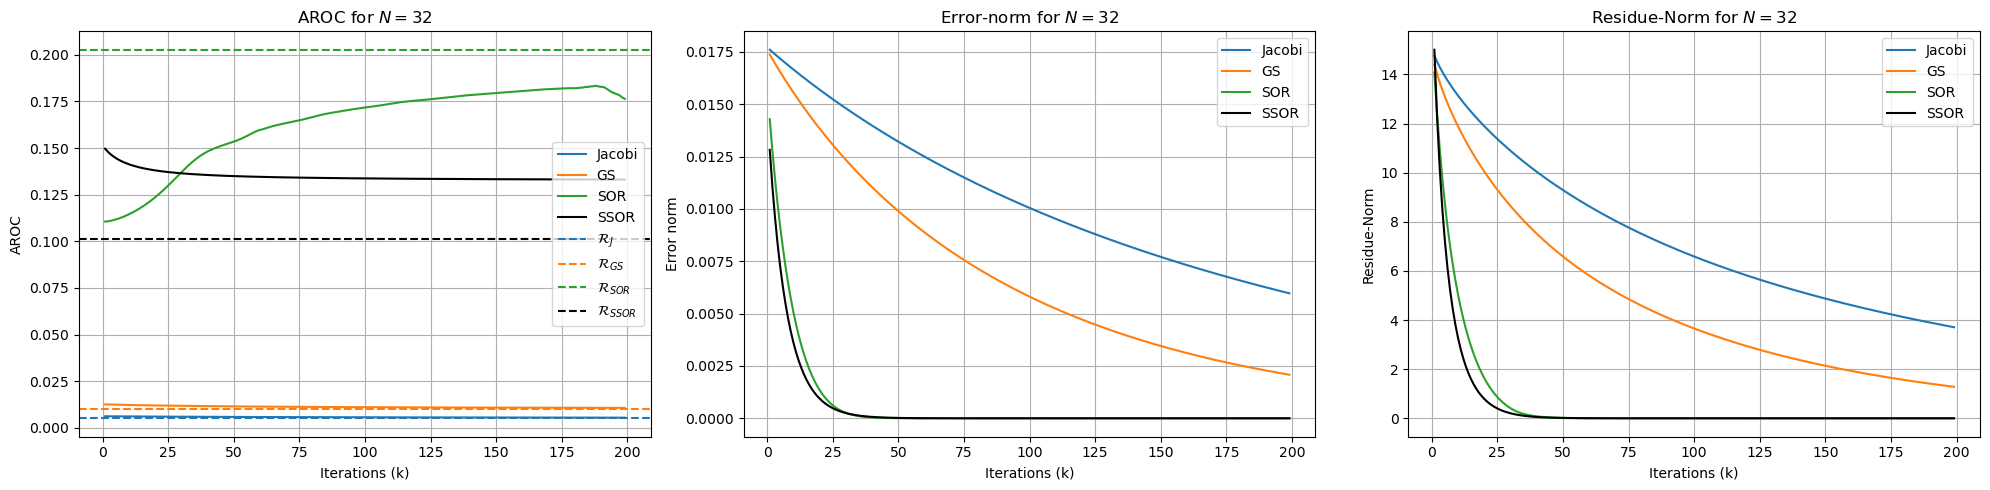

In [15]:
# Plot AROC, Error-Norm, Residue-Norm
# Slice the arrays from index 0 to 100
start, end = 1, 200
time = np.arange(start, end)

# Create subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# === AROC Plot ===
axs[0].plot(time, jacobi_32["aroc"][start:end], label='Jacobi', color='#1f77b4')  
axs[0].plot(time, gs_32["aroc"][start:end], label='GS', color='#ff7f0e')  
axs[0].plot(time, sor_32["aroc"][start:end], label='SOR', color='#2ca02c')  
axs[0].plot(time, ssor_32["aroc"][start:end], label='SSOR', color='#000000')

# Add dashed horizontal lines for theoretical AROC values
axs[0].axhline(y=aroc_jacobi32, linestyle='--', color='#1f77b4', label='$\\mathcal{R}_{J}$', linewidth=1.5)
axs[0].axhline(y=aroc_gs32, linestyle='--', color='#ff7f0e',  label='$\\mathcal{R}_{GS}$', linewidth=1.5)
axs[0].axhline(y=aroc_sor32, linestyle='--', color='#2ca02c', label='$\\mathcal{R}_{SOR}$', linewidth=1.5)
axs[0].axhline(y=aroc_ssor32, linestyle='--', color='#000000', label='$\\mathcal{R}_{SSOR}$', linewidth=1.5)

# # # Add dashed vertical lines for theoretical k values
# # axs[0].axvline(x=k_jacobi_theoretical, linestyle=':', color='#1f77b4', alpha=0.8, label='$K_{J}$')
# # axs[0].axvline(x=k_gs_theoretical, linestyle=':', color='#ff7f0e', alpha=0.8, label='$K_{GS}$')
# # axs[0].axvline(x=k_sor_theoretical, linestyle=':', color='#2ca02c', alpha=0.8, label='$K_{SOR}$')
# # axs[0].axvline(x=k_ssor_theoretical, linestyle=':', color='#000000', alpha=0.8, label='$K_{SSOR}$')

# # === Error Norm Plot ===
axs[1].plot(time, jacobi_32["err"][start:end], label='Jacobi', color='#1f77b4')  
axs[1].plot(time, gs_32["err"][start:end], label='GS', color='#ff7f0e')  
axs[1].plot(time, sor_32["err"][start:end], label='SOR', color='#2ca02c')  
axs[1].plot(time, ssor_32["err"][start:end], label='SSOR', color='#000000')


# # Add dashed vertical lines for theoretical k values
# # axs[1].axvline(x=k_jacobi_theoretical, linestyle=':', color='#1f77b4', alpha=0.8, label='$K_{J}$')
# # axs[1].axvline(x=k_gs_theoretical, linestyle=':', color='#ff7f0e', alpha=0.8, label='$K_{GS}$')
# axs[1].axvline(x=k_sor_theoretical, linestyle=':', color='#2ca02c', alpha=0.8, label='$K_{SOR}$')
# axs[1].axvline(x=k_ssor_theoretical, linestyle=':', color='#000000', alpha=0.8, label='$K_{SSOR}$')

# # === Residue Plot ===
axs[2].plot(time, jacobi_32["res"][start:end], label='Jacobi', color='#1f77b4')  
axs[2].plot(time, gs_32["res"][start:end], label='GS', color='#ff7f0e')  
axs[2].plot(time, sor_32["res"][start:end], label='SOR', color='#2ca02c')  
axs[2].plot(time, ssor_32["res"][start:end], label='SSOR', color='#000000')


# # Add dashed vertical lines for theoretical k values
# # axs[2].axvline(x=k_jacobi_theoretical, linestyle=':', color='#1f77b4', alpha=0.8, label='$K_{J}$')
# # axs[2].axvline(x=k_gs_theoretical, linestyle=':', color='#ff7f0e', alpha=0.8, label='$K_{GS}$')
# axs[2].axvline(x=k_sor_theoretical, linestyle=':', color='#2ca02c', alpha=0.8, label='$K_{SOR}$')
# axs[2].axvline(x=k_ssor_theoretical, linestyle=':', color='#000000', alpha=0.8, label='$K_{SSOR}$')



axs[0].set_title('AROC for $N=32$')
axs[0].set_xlabel('Iterations (k)')
axs[0].set_ylabel('AROC')
axs[0].grid(True)
axs[0].legend()


axs[1].set_title('Error-norm for $N=32$')
axs[1].set_xlabel('Iterations (k)')
axs[1].set_ylabel('Error norm')
axs[1].grid(True)
axs[1].legend()

axs[2].set_title('Residue-Norm for $N=32$')
axs[2].set_xlabel('Iterations (k)')
axs[2].set_ylabel('Residue-Norm')
axs[2].grid(True)
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


### Visualize the final solution $U[i,j]$ to compare the different solvers

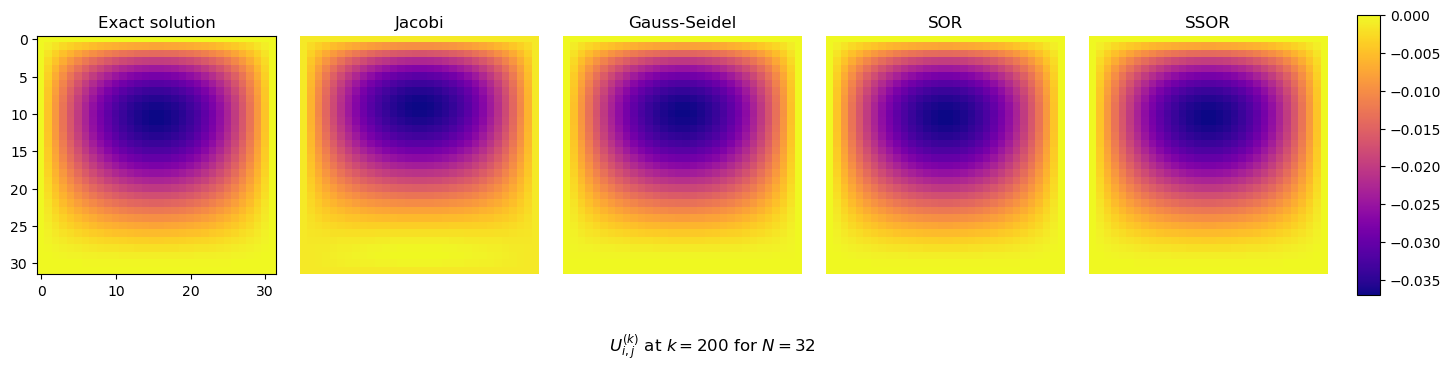

In [16]:
# Plot Final solution
# Create figure with specific size
fig = plt.figure(figsize=(15, 4))

# Define GridSpec: 1 row, 5 columns
grid_spec = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1], wspace=0.1)

# Exact solution (first plot)
ax0 = fig.add_subplot(grid_spec[0])
im = ax0.imshow(AnalyticalSolution(32), cmap='plasma')
ax0.set_title('Exact solution')

# Keep ticks only on exact solution
ax0.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

# Other four plots (next 4 plots in the row)
ax1 = fig.add_subplot(grid_spec[1])
ax2 = fig.add_subplot(grid_spec[2])
ax3 = fig.add_subplot(grid_spec[3])
ax4 = fig.add_subplot(grid_spec[4])

# Plot each
ax1.imshow(jacobi_32["Uk"], cmap='plasma')
ax1.set_title('Jacobi')
ax1.axis('off')

ax2.imshow(gs_32["Uk"], cmap='plasma')
ax2.set_title('Gauss-Seidel')
ax2.axis('off')

ax3.imshow(sor_32["Uk"], cmap='plasma')
ax3.set_title('SOR')
ax3.axis('off')

ax4.imshow(ssor_32["Uk"], cmap='plasma')
ax4.set_title('SSOR')
ax4.axis('off')

# Shared colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

# Final layout adjustments
plt.subplots_adjust(left=0.05, right=0.91, top=0.92, bottom=0.08)
fig.text(0.5, 0.02, f"$U_{{i,j}}^{{(k)}}$ at $k = 200$ for $N = 32$", ha='center', va='center', fontsize=12)

plt.show()


<html><br></html>

--------------------------------------------------------

--------------------------------------------------------

<html><br></html>

<h2 style = "color:red"  > Homework 1.10</h2>

For the Jacobi method and Gauss-Seidel method, graph $ -\ln \mathcal{R}_{100}$ versus $\ln N = −\ln h$ for $N = 16, 32, 64$. \
For the SOR method (for $\omega = \omega_{opt}$), and SSOR method (for $\omega = \omega_{good}$), compute and graph $ -\ln \mathcal{R}_{100}$ versus $\ln N = −\ln h$ for $N = 16, 32, 64$\
Compare the dependence of $\mathcal{R}$ on $h$ with the theoretical dependence of $\mathcal{R}$ predicted in (1.37)

## Answer 1.10
The theoretical dependance of $\mathcal{R}$ vs $N$ is given by \
$\mathcal{R}(G_J) \approx \pi^2 h^2/2$ \
$\mathcal{R}(H_1) \approx \pi^2 h^2$ \
$\mathcal{R}(H_{\omega_{opt}}) \approx 2 \pi h$ \
$\mathcal{R}(G_{\omega_{good}}) \approx \pi h$

Therefore $- \ln \mathcal{R}$ depends on $\ln N$ as \
$ - \ln \mathcal{R}(G_J) \approx 2\ln(N) + \ln(2/\pi^2)$ \
$ - \ln \mathcal{R}(H_1) \approx 2\ln(N) + \ln(1/\pi^2)$ \
$ - \ln \mathcal{R}(H_{\omega_{opt}}) \approx \ln(N) -\ln(2\pi)$ \
$ - \ln \mathcal{R}(G_{\omega_{good}}) \approx \ln(N) -\ln(\pi)$

In [17]:
# Solve Jacobi, GS, SOR, SSOR for N = 16
jacobi_16 = JacobiSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), max_iter = 200)
gs_16 = GaussSeidelSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), max_iter = 200)
sor_16 = SORSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), omega = OmegaOpt(16), max_iter = 200)
ssor_16 = SSORSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), omega = OmegaGood(16), max_iter = 200)

In [18]:
# Solve Jacobi, GS, SOR, SSOR for N = 64
jacobi_64 = JacobiSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), max_iter = 200)
gs_64 = GaussSeidelSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), max_iter = 200)
sor_64 = SORSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), omega = OmegaOpt(64), max_iter = 200)
ssor_64 = SSORSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), omega = OmegaGood(64), max_iter = 200)

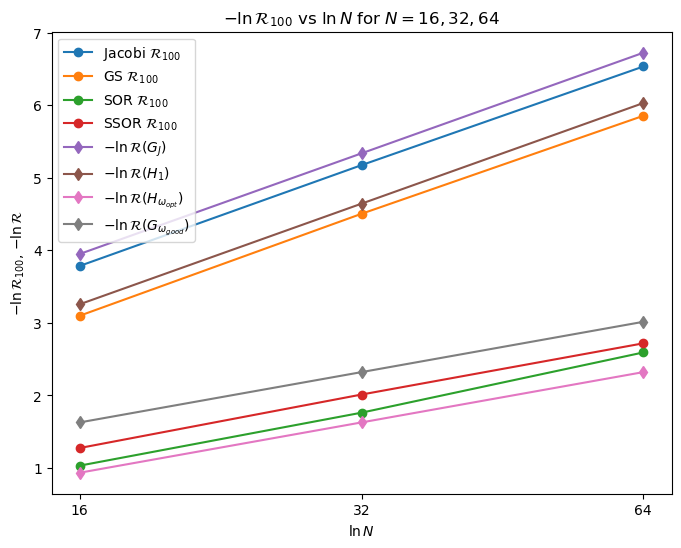

In [19]:
# plot AROC vs N 
plt.figure(figsize=(8,6))

plt.plot( 
    np.log(np.array([16,32,64])),
    (-1)*np.log(np.array([jacobi_16["aroc"][100], jacobi_32["aroc"][100], jacobi_64["aroc"][100]])),
    label = "Jacobi $\\mathcal{R}_{100}$",
    marker = "o"
)

plt.plot( 
    np.log(np.array([16,32,64])),
    (-1)*np.log(np.array([gs_16["aroc"][100], gs_32["aroc"][100], gs_64["aroc"][100]])),
    label = "GS $\\mathcal{R}_{100}$",
    marker = "o"
)

plt.plot( 
    np.log(np.array([16,32,64])),
    (-1)*np.log(np.array([sor_16["aroc"][100], sor_32["aroc"][100], sor_64["aroc"][100]])),
    label = "SOR $\\mathcal{R}_{100}$",
    marker = "o"
)
plt.plot( 
    np.log(np.array([16,32,64])),
    (-1)*np.log(np.array([ssor_16["aroc"][100], ssor_32["aroc"][100], ssor_64["aroc"][100]])),
    label = "SSOR $\\mathcal{R}_{100}$",
    marker = "o"
)

# plot the theoretical values for -lnR
plt.plot(np.log([16,32,64]), [2 * np.log(x) + np.log(2/np.pi**2) for x in [16,32,64]], label = "$- \\ln \\mathcal{R}(G_J)$", marker = "d")
plt.plot(np.log([16,32,64]), [2 * np.log(x) + np.log(1/np.pi**2) for x in [16,32,64]], label = "$- \\ln \\mathcal{R}(H_1)$", marker = "d")
plt.plot(np.log([16,32,64]), [np.log(x) - np.log(2 * np.pi) for x in [16,32,64]], label = "$- \\ln \\mathcal{R}(H_{\\omega_{opt}})$", marker = "d")
plt.plot(np.log([16,32,64]), [np.log(x) - np.log(np.pi) for x in [16,32,64]], label = "$- \\ln \\mathcal{R}(G_{\\omega_{good}})$", marker = "d")

plt.ylabel("$-\\ln \\mathcal{R}_{100}$, $-\\ln \\mathcal{R}$")
plt.xlabel("$\\ln N$")

plt.title(f"$- \\ln \\mathcal{{R}}_{{100}}$ vs $\\ln N$ for $N=16,32,64$")
plt.legend()
plt.xticks(np.log([16, 32, 64]), ["16", "32", "64"])
plt.show()

### Conclusions
- From the above plots it is clear that $-\ln \mathcal{R}_{100}$ has a linear relation with $\ln N$ and it agrees with the theoretical value of $-\ln \mathcal{R}$ for the various solvers. 
- For Jacobi and Gauss-Seidel, the line has slope 2.
- For SOR and SSOR, the line has slope 1


<html><br></html>

--------------------------------------------------------

--------------------------------------------------------

<html><br></html>

<h2 style = "color:red"  > Homework 1.11</h2>

For the SOR and SSOR methods with $N = 16, 32, 64$, graph $-\ln \mathcal{R}_{100}$ vs $\omega$ for $\omega = 1 + 0.5 l$ for $ l = 0,1,...20$.  \
Interpret this graph using the result (1.33) and the theory in this section.

## Answer 1.11 
#### 1.11 a) Analysis for SOR
First we need to evalue the $\mathcal{R}(H_{\omega})_{100}$ for SOR for a range of $\omega$s at $N=16,32,64$. \
The following code does that and stores the values in 3 arrays for future reference

In [20]:
# evalute SOR's AROC for a range of omegas, for N = 16, 32, 64
omega_vals = np.linspace(1.0, 2.0, 20)
sor16_aroc_100 = np.array([])
sor32_aroc_100 = np.array([])
sor64_aroc_100 = np.array([])

for o in omega_vals:
    sor16_omega = SORSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), omega = o, max_iter = 150)
    sor32_omega = SORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = o, max_iter = 150)
    sor64_omega = SORSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), omega = o, max_iter = 150)
    sor16_aroc_100 = np.append(sor16_aroc_100, sor16_omega["aroc"][100])
    sor32_aroc_100 = np.append(sor32_aroc_100, sor32_omega["aroc"][100])
    sor64_aroc_100 = np.append(sor64_aroc_100, sor64_omega["aroc"][100])

Now that we've evaluated the $\mathcal{R}(H_{\omega})_{100}$ for SOR for a range of $\omega$s at $N=16,32,64$ we need to compare that to the spectral radius of SOR's iteration matrix which is given by:
\begin{equation}
\rho(H_{\omega}) =
\begin{cases}
\left(
    \dfrac{
        \omega \rho(G_J)
        + \sqrt{ \omega^2 \rho(G_J)^2 - 4(\omega - 1) }
    }{2}
\right)^{\!2},
& \text{for } 1 \le \omega \le \omega_{\mathrm{opt}}, \\[1.2em]
\omega - 1, & \text{for } \omega \ge \omega_{\mathrm{opt}}.
\end{cases}
\end{equation}

where $\rho(G_J) = \cos(\pi h)$ is the spectral-radius of the Jacobi iteration matrx 

The following bit of code translates the above equation into Python

In [21]:
# evaluate the spectral-radius of a Jacobi Iteration Matrix
def rho_GJ(N):
    h = 1/(N-1)
    return np.cos(np.pi * h)

# evaluate the spectral radius of SOR iteration matrix
def rho_H(omega, N):
    omega_opt = OmegaOpt(N)
    if 1 <= omega < omega_opt:
        t1 = 4*(omega-1) 
        t2 = omega*rho_GJ(N)
        t3 = np.sqrt(t2**2 - t1)
        t4 = t2 + t3
        return (t4**2)/4
    elif omega >= omega_opt:
        return omega - 1
    else:
        raise ValueError("omega must be >= 1")


Now that we have the helper functions $\texttt{rho\_GJ(N)}$ and $\texttt{rho\_H(omega,N)}$ we can use them to evaluate the spectral-radius of the SOR iteration matrix for a range of $\omega$s \
The following bit of code does that and stores the values in 3 arrays for future reference

In [22]:
# evaluate spectral-radius of SOR matrix for a range of omegas for N = 16,32,64
sor16_rho = np.array([])
sor32_rho = np.array([])
sor64_rho = np.array([])

for o in omega_vals:
    sor16_rho = np.append(sor16_rho, rho_H(o,16))
    sor32_rho = np.append(sor32_rho, rho_H(o,32))
    sor64_rho = np.append(sor64_rho, rho_H(o,64))

We've succesfully evaluated the $\mathcal{R}_{100}$ and $\rho(H_{\omega})$ for SOR for a range of $\omega$s at $N=16,32,64$. \
We can plot them against $\omega$ to confirm that $\mathcal{R}_{100}$ and $-\ln \rho(H_{\omega})$ are the same

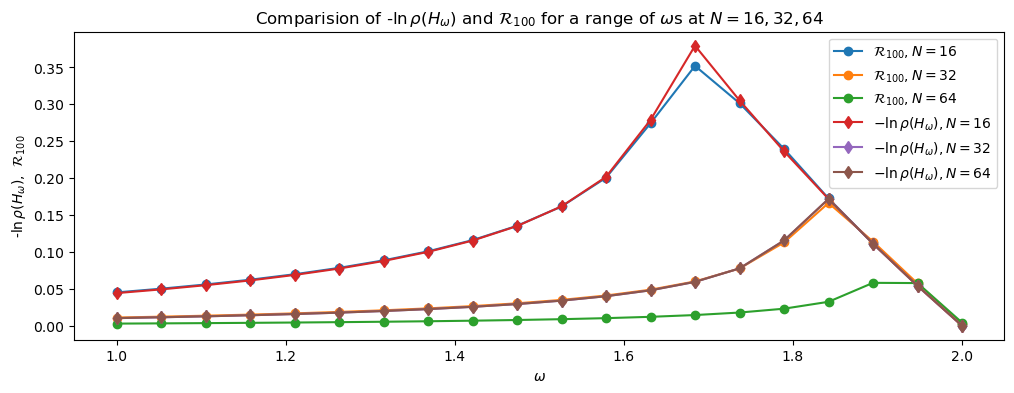

In [23]:

plt.figure(figsize=(12,4))
plt.plot(omega_vals,sor16_aroc_100, marker="o",label = "$\\mathcal{R}_{100}, N=16$")
plt.plot(omega_vals,sor32_aroc_100, marker="o",label = "$\\mathcal{R}_{100}, N=32$")
plt.plot(omega_vals,sor64_aroc_100, marker="o",label = "$\\mathcal{R}_{100}, N=64$")


plt.plot(omega_vals, (-1)*np.log(sor16_rho), marker = "d", label = "$-\\ln \\rho(H_{\\omega}), N=16$")
plt.plot(omega_vals, (-1)*np.log(sor32_rho), marker = "d", label = "$-\\ln \\rho(H_{\\omega}), N=32$")
plt.plot(omega_vals, (-1)*np.log(sor32_rho), marker = "d", label = "$-\\ln \\rho(H_{\\omega}), N=64$")

plt.title("Comparision of -$\\ln \\rho(H_{\\omega})$ and $\\mathcal{R}_{100}$ for a range of $\\omega$s at $N=16,32,64$")
plt.ylabel("-$\\ln \\rho(H_{\\omega})$,  $\\mathcal{R}_{100}$")
plt.xlabel("$\\omega$")
plt.legend()
plt.show()

#### 1.11 b) Repeating the same analysis for SSOR ...

In [24]:
# evalute SOR's AROC for a range of omegas, for N = 16, 32, 64
omega_vals = np.linspace(1.0, 2.0, 20)
ssor16_aroc_100 = np.array([])
ssor32_aroc_100 = np.array([])
ssor64_aroc_100 = np.array([])

for o in omega_vals:
    ssor16_omega = SSORSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), omega = o, max_iter = 150)
    ssor32_omega = SSORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = o, max_iter = 150)
    ssor64_omega = SSORSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), omega = o, max_iter = 150)
    ssor16_aroc_100 = np.append(ssor16_aroc_100, ssor16_omega["aroc"][100])
    ssor32_aroc_100 = np.append(ssor32_aroc_100, ssor32_omega["aroc"][100])
    ssor64_aroc_100 = np.append(ssor64_aroc_100, ssor64_omega["aroc"][100])

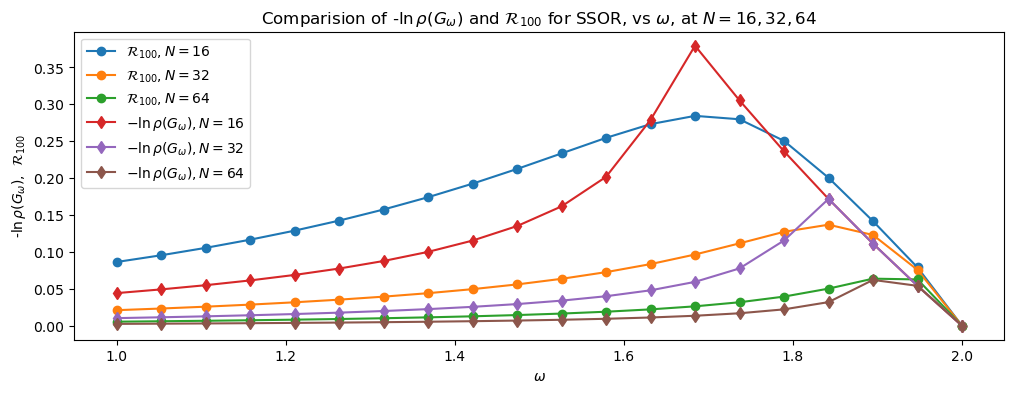

In [25]:
# plot AROC and spectral-radius for SSOR for a range of omegas at N = 16,32,64
plt.figure(figsize=(12,4))
plt.plot(omega_vals,ssor16_aroc_100, marker="o",label = "$\\mathcal{R}_{100}, N=16$")
plt.plot(omega_vals,ssor32_aroc_100, marker="o",label = "$\\mathcal{R}_{100}, N=32$")
plt.plot(omega_vals,ssor64_aroc_100, marker="o",label = "$\\mathcal{R}_{100}, N=64$")


plt.plot(omega_vals, (-1)*np.log(sor16_rho), marker = "d", label = "$-\\ln \\rho(G_{\\omega}), N=16$")
plt.plot(omega_vals, (-1)*np.log(sor32_rho), marker = "d", label = "$-\\ln \\rho(G_{\\omega}), N=32$")
plt.plot(omega_vals, (-1)*np.log(sor64_rho), marker = "d", label = "$-\\ln \\rho(G_{\\omega}), N=64$")

plt.title("Comparision of -$\\ln \\rho(G_{\\omega})$ and $\\mathcal{R}_{100}$ for SSOR, vs $\\omega$, at $N=16,32,64$")
plt.ylabel("-$\\ln \\rho(G_{\\omega})$,  $\\mathcal{R}_{100}$")
plt.xlabel("$\\omega$")
plt.legend()
plt.show()

### Conclusions
The smoothness of SSOR's $\mathcal{R}_{100}$ curve indicates that SSOR is less sensitive to changes in $\omega$ when $\omega \approx \omega_{Good}$. \
This is unlike the sharp peak observed for SOR's $\mathcal{R}_{100}$ curve which indicates that SOR is very sensitive to changes in $\omega$ when $\omega \approx \omega_{opt}$.